In [1]:
# Note that the struct's contents are different from the previous ones
struct Models
    # parameters
    β::Float64 # discount factor
    γ::Float64 # relative risk aversion
    
    # factor price
    rent::Float64 # net interest rate
    
    # grid
    na::Int64 # the number of saving grid
    a_max::Float64 # the maximum value of saving grid
    a_min::Float64 # the minimum value of saving grid
    grid_a::Vector{Float64} # saving grid
end

In [2]:
function Calibration()
    # set parameters here
    β = 0.985^30
    γ = 2.0
    rent = 1.025^30 - 1.0
    na = 11
    a_max = 0.4
    a_min = 0.0

    grid_a = collect(LinRange(a_min, a_max, na))

    return Models(β, γ, rent, na, a_max, a_min, grid_a)
end

Calibration (generic function with 1 method)

In [3]:
function mu_CRRA(cons, γ)
    return cons^(-γ)
end

mu_CRRA (generic function with 1 method)

In [14]:
# Load the required packages
using Plots

## Endogenous gridpoint method
<!-- ## 内生的格子法 -->

- The methods for optimization and root-finding of nonlinear equations use optimization libraries
<!-- - 最適化や非線形方程式の根を探す方法は、最適化ライブラリを用いている。 -->

- When we solve more complex models, the steps of optimization and root-finding can be bottle neck
<!-- - より複雑なモデルでは、最適化や非線形方程式の根を探すステップがボトルネックになる。 -->

- For projection methods, the step of root-finding is only once, but it takes much more time to find coefficients of higher order polynomials
<!-- - 射影法の場合、ゼロ点を探すステップは1回限りであるが、多項式の次数を上げると、やはり係数を探す時間が大幅に増加する。 -->

- Endogenous Gridpoint Method, EGM, a la Caroll (2006) considers how to make grid, based on the Euler equation.
<!-- - Carroll(2006)による内生的格子法（Endogenous Gridpoint Method, EGM）は、オイラー方程式に基づきながら、グリッドの取り方を工夫する。 -->

- If we can use EGM when we solve the model, we can significantly improve the speed of computation by saving the steps of iterative calculation.
<!-- - EGMを使うことが出来るモデルであれば、繰り返し計算のステップを節約することで、計算速度を大幅にアップできる。 -->

- So far, we have directly solved the problem on how much an economic agent with current income $w$ saves $a$ to maximize the lifetime utility
<!-- - これまでは、現在の所得が$w$である経済主体が生涯効用を最大にするためにはどの程度貯蓄$a$をすればよいか、という問題をダイレクトに解いていた。 -->

- Now, with EGM, we discretize the control variable $a$, not the state variable $w$, and calculate the state variable by thinking backward from the budget constraint
<!-- - 一方、EGMでは状態変数である$w$ではなく操作変数である$a$を離散化して、状態変数については予算制約から逆算する。 -->

- Algorithm
<!-- - アルゴリズム -->

1. Set parameters (calibration)

2. Let $a_{j} \in \{a_{1},\dots,a_{I}\}$ be discretized assets in the old period

3. Define the right-hand side of the Euler eqution by
$$
  \Gamma(a_{j}) \equiv \beta (1+r) [(1+r)a_{j}]^{-\gamma}
$$
As $(\beta,\gamma,r)$ are parameter values, we can easily calculate the above equation once we fix the value of $a_{j}$

<!-- 1. パラメータを設定する（カリブレーション）。

2. $a_{j} \in \{a_{1},\dots,a_{I}\}$を離散化した老年期の資産とする。

3. オイラー方程式の右辺を、
$$
  \Gamma(a_{j}) \equiv \beta (1+r) [(1+r)a_{j}]^{-\gamma}
$$
と定義する。$(\beta,\gamma,r)$はパラメータなので、$a_{j}$を一つ定めれば、上式は容易に計算できる。 -->

4. From the Euler equation, we have $u'(c_{1})=c_{1}^{-\gamma}=\Gamma (a_{j})$. Taking the inverse function of the marginal utility, we can solve for
$$
  c_{1} = \Gamma (a_{j})^{-\frac{1}{\gamma}}
$$

5. Calculate the steps 3-4 for all the discretized $a_{j}$, and then we obtain $c_{1,j}$ satisfying the Euler equation with a given $a_{j}$, that is, the optimal consumption-saving choice $(c_{1},a)$. As the budget constraint is $c_{1,j}+a_{j}=w_{j}$, it means that we compute the optimal consumption-saving choice with a given income $w_{j}$

<!-- 4. オイラー方程式より$u'(c_{1})=c_{1}^{-\gamma}=\Gamma (a_{j})$である。限界効用関数の逆関数をとり、
$$
  c_{1} = \Gamma (a_{j})^{-\frac{1}{\gamma}}
$$
を計算することができる。

5. ステップ3-4を離散化したあらゆる$a_{j}$について計算すれば、ある$a_{j}$の下でオイラー方程式を満たす$c_{1,j}$、すなわち最適な消費$c_{1}$と貯蓄$a$の組み合わせを計算したことになる。予算制約は$c_{1,j}+a_{j}=w_{j}$なので、所得$w_{j}$の下での最適な消費と貯蓄の組み合わせが計算できたことになる。 -->

In [7]:
function rhs_euler(a::Float64, params::Models)

    # The marginal utility when old
    mu = mu_CRRA((1.0 + params.rent)*a, params.γ)

    # The right-hand side of the Euler equation
    return params.β*(1.0 + params.rent)*mu

end

rhs_euler (generic function with 1 method)

In [8]:
function inv_mu_CRRA(mu, γ)
    return mu^(-1/γ)
end

inv_mu_CRRA (generic function with 1 method)

In [9]:
# Set parameters
params = Calibration()

# Prepare empty variables
rhs = zeros(params.na)
cons = zeros(params.na)

for j = 1:params.na
    # Calculate the right-hand side of the Euler equation
    rhs[j] = rhs_euler(params.grid_a[j], params)
    # Calculate consumption when young by the inverse function
    cons[j] = inv_mu_CRRA(rhs[j], params.γ)
end

w = zeros(params.na)
for j = 1:params.na
    w[j] = cons[j] + params.grid_a[j]
end
print(w)

[0.0, 0.11267323864644622, 0.22534647729289245, 0.3380197159393386, 0.4506929545857849, 0.563366193232231, 0.6760394318786772, 0.7887126705251233, 0.9013859091715698, 1.0140591478180159, 1.126732386464462]

In [12]:
# Analytical solution: Eq. (2.4)
coef1 = (params.β*(1.0+params.rent))^(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0+params.rent))
a_cfs = coef2*w;

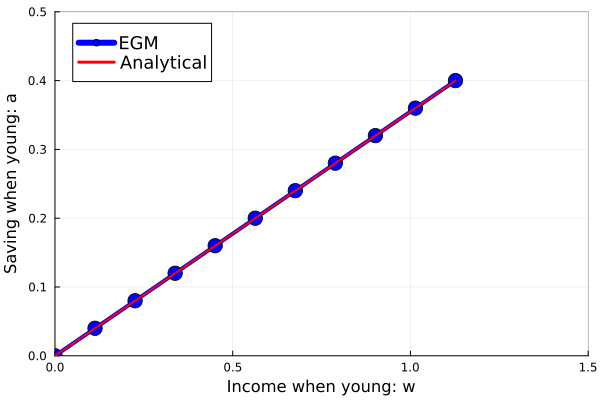

In [13]:
plt = plot(w, params.grid_a,
    color = :blue,
    marker = :circle,
    legend = :topleft,
    xlims = (0, 1.5),
    ylims = (0, 0.5),
    label = ("EGM"),
    xlabel = ("Income when young: w"),
    ylabel = ("Saving when young: a"),
    linewidth = 4,
    markersize = 8,
#     titlefont = font("HackGen35Nerd", 12),
#     guidefont = font("HackGen35Nerd", 12),
#     tickfont = font("HackGen35Nerd", 8),
#     legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(w, a_cfs, linewidth = 2, color = :red, label="Analytical")
#savefig("../figure/Fig2_pol_egm.pdf")